In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv(r'C:\Users\vlogs\OneDrive\Desktop\Churn Prediction\Data\cleaned_churn_data.csv')

# Drop customerID immediately
df.drop('customerID', axis=1, inplace=True)


In [2]:


print("=== TOTAL NaNs per column ===")
print(df.isna().sum())


=== TOTAL NaNs per column ===
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [3]:
# Map binary columns if not numeric yet
binary_cols = ['Churn', 'SeniorCitizen']
for col in binary_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].map({'Yes': 1, 'No': 0})

# Separate categorical and numeric columns
cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

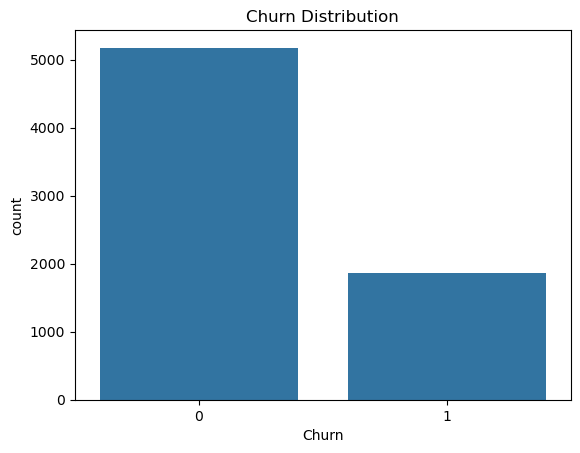

Churn value counts:
Churn
0    73.463013
1    26.536987
Name: proportion, dtype: float64


In [4]:
#2.1 Target Variable Distribution
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

print("Churn value counts:")
print(df['Churn'].value_counts(normalize=True) * 100)


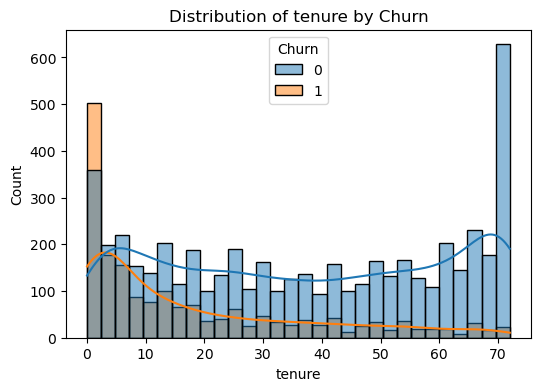

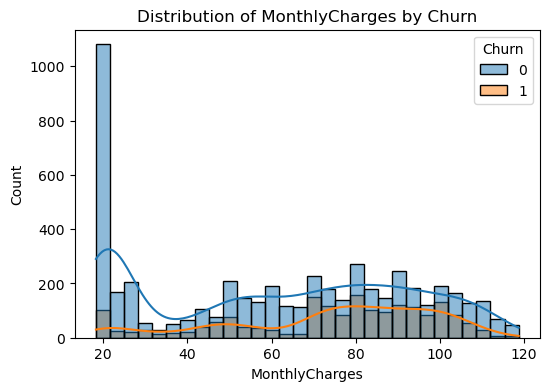

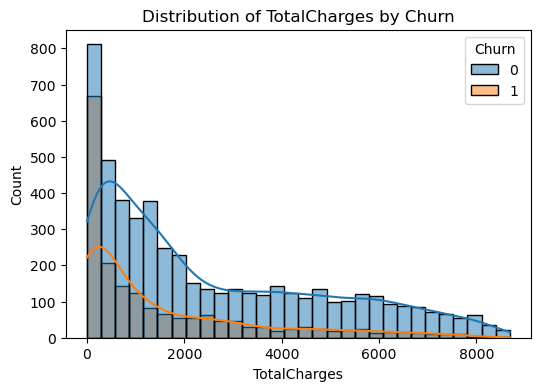

In [5]:
#2.2 Numeric Feature Distributions & Churn Relationship
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=col, hue='Churn', kde=True, bins=30)
    plt.title(f'Distribution of {col} by Churn')
    plt.show()


In [6]:
# One-hot encode multi-category categoricals
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Split features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


print(X_train.columns)




Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes',
       'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')


In [7]:
# Feature scaling
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_proba_lr = lr.predict_proba(X_test)[:, 1]

print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_lr):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba_lr):.4f}")

Logistic Regression Performance:
Accuracy: 0.8062
Precision: 0.6593
Recall: 0.5588
F1 Score: 0.6049
ROC-AUC: 0.8422


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# List of streaming-related columns
streaming_cols = [
    'StreamingTV_No internet service', 'StreamingTV_Yes',
    'StreamingMovies_No internet service', 'StreamingMovies_Yes'
]

# Prepare two datasets: with and without streaming cols
X_train_with = X_train.copy()
X_test_with = X_test.copy()

X_train_without = X_train.drop(columns=streaming_cols)
X_test_without = X_test.drop(columns=streaming_cols)

def train_eval_rf(X_tr, y_tr, X_te, y_te):
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_tr, y_tr)
    y_pred = rf.predict(X_te)
    y_proba = rf.predict_proba(X_te)[:,1]
    return {
        'Accuracy': accuracy_score(y_te, y_pred),
        'Precision': precision_score(y_te, y_pred),
        'Recall': recall_score(y_te, y_pred),
        'F1': f1_score(y_te, y_pred),
        'ROC-AUC': roc_auc_score(y_te, y_proba)
    }

# Train & evaluate with streaming features
metrics_with = train_eval_rf(X_train_with, y_train, X_test_with, y_test)

# Train & evaluate without streaming features
metrics_without = train_eval_rf(X_train_without, y_train, X_test_without, y_test)

print("Metrics WITH streaming features:")
print(metrics_with)

print("\nMetrics WITHOUT streaming features:")
print(metrics_without)


Metrics WITH streaming features:
{'Accuracy': 0.7849538679914834, 'Precision': 0.6187290969899666, 'Recall': 0.4946524064171123, 'F1': 0.549777117384844, 'ROC-AUC': 0.8248417680642744}

Metrics WITHOUT streaming features:
{'Accuracy': 0.794889992902768, 'Precision': 0.6470588235294118, 'Recall': 0.5, 'F1': 0.5641025641025641, 'ROC-AUC': 0.8237929163760366}
